<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Pui/Knock_Out_Call_jax_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   4647      0 --:--:-- --:--:-- --:--:--  4633
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 31 kB/s 
     |████████████████████████████████| 1.0 MB 51.0 MB/s 
+ set +ex
Installation succeeded!


# Test (Skip this if not trying to test, to make sure that functions are defined correctly in cells below without running this cell)

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T): # down-and-out call
    return jnp.mean(jnp.maximum((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int))* 
                                (jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))[:,-1]-K, 0) *
                    jnp.exp(-r[0] * T))

numstocks = 3
numsteps = 50
numpaths = 100000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.5*0.5
initial_stocks = jnp.array([100.]*numstocks) # must be float
T = 1.0
K = 60.0
B = 78.4 # if B is set to 0, equivalent to European call

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
keys = jax.random.split(key, 100000)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T))
%timeit optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T)

# delta
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T))
%timeit goptionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T)

32.85719
[0.22481976 0.22449198 0.22490814]


# Construct Neural Net

In [1]:
%%writefile cupy_dataset.py
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, keys): # down-and-out call
    return jnp.mean(jnp.maximum((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int))* 
                                (jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))[:,-1]-K, 0) *
                    jnp.exp(-r[0] * T))

###################################################################################################
# these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
###################################################################################################

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 7), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          rng = jax.random.PRNGKey(self.seed)
          rng, key = jax.random.split(rng)

          ################################################################################################### generate random input numbers

          initial_stocks = jnp.array(np.random.random(self.N_STOCKS) * 200.0)

          corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
          sigma = jnp.array(np.random.random(self.N_STOCKS) * 0.4)
          cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

          r = jnp.repeat(jnp.array(np.random.random(1) * 0.1), self.N_STOCKS)
          drift = jnp.array(np.random.random(self.N_STOCKS) * 0.2)

          T = self.T
          K = np.random.random(1) * 200.0
          B = np.random.random(1) * 200.0 * 0.9 # B can't be too large

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas
          
          keys = jax.random.split(key, self.N_PATHS)

          European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, B, T, keys) # need to pass 'keys'
          gooptionvalue = jax.grad(optionvalueavg, argnums=1)
          Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, B, T, keys) # need to pass 'keys'

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price
          Y[op, 1:4] = cupy.array(Deltas, dtype=cupy.float32)

          # T, B, K, S, sigma, mu, r
          paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(B), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = OptionDataSet(max_len = 2, number_path = 10000, batch = 3, seed = 15, stocks=3) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

Writing cupy_dataset.py


In [3]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7*3, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 4) # 4 outputs: price, delta1, delta2, delta3
        self.register_buffer('norm',
                             torch.tensor([1, 200.0*0.9, 200.0, 200.0, 0.4, 0.2, 0.1]*3)) # don't use numpy here - will give error later
                                                                                          # T, B, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Overwriting model.py


# Train Neural Net

In [4]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 15.1 MB/s 


In [5]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 3) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    # print(y)
    y_pred = model(x)
    # print(y_pred)
    # print(y.mean(axis=0))
    loss_weight = y.mean(axis=0)[0]/y.mean(axis=0)
    # loss_weight = torch.tensor([1, 50, 50, 50]).cuda() # switch to this so that more weight is assigned to price
    loss_weight_normalized = loss_weight/loss_weight.sum()
    # print(loss_weight)
    # print(loss_weight_normalized)
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean() * 100 # compute weighted MSE between the 2 arrays
    # print((y_pred - y) ** 2)
    # print((y_pred - y) ** 2 * loss_weight_normalized)
    # print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  


loss 0.21573415398597717 average time 0.5524972275499976 iter num 20
loss 0.5041149854660034 average time 0.27771978017501053 iter num 40
loss 0.4529551863670349 average time 0.18610052670000338 iter num 60
loss 0.47228682041168213 average time 0.14032825667500076 iter num 80
loss 0.2646041214466095 average time 0.11285470184999895 iter num 100
loss 0.15927483141422272 average time 0.07082559605000824 iter num 20
loss 0.12746113538742065 average time 0.036819739824994716 iter num 40
loss 0.13059252500534058 average time 0.0255166225333312 iter num 60
loss 0.04682614654302597 average time 0.019840630324998186 iter num 80
loss 0.10658369958400726 average time 0.016440676769996117 iter num 100
loss 0.0429360494017601 average time 0.06938878285001807 iter num 20
loss 0.044093430042266846 average time 0.036122561250010676 iter num 40
loss 0.09273669123649597 average time 0.025020603600008448 iter num 60
loss 0.12930044531822205 average time 0.01947083567500556 iter num 80
loss 0.03782146424

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

**Save Model**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import torch
model_save_name = 'jax_knockout_test_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
model_save_name = 'jax_knockout_test_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

In [ ]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

**Continue to train model**

In [ ]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 3) # must have random seed
dataset = OptionDataSet(max_len = 100, number_path = 10000, batch = 8, seed = np.random.randint(10000), stocks = 3) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    # print(y)
    y_pred = model(x)
    # print(y_pred)
    # print(y.mean(axis=0))
    # loss_weight = y.mean(axis=0)[0]/y.mean(axis=0)
    loss_weight = torch.tensor([1, 50, 50, 50]).cuda() # switch to this so that more weight is assigned to price
    loss_weight_normalized = loss_weight/loss_weight.sum()
    # print(loss_weight)
    # print(loss_weight_normalized)
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean() * 100 # compute weighted MSE between the 2 arrays
    # print((y_pred - y) ** 2)
    # print((y_pred - y) ** 2 * loss_weight_normalized)
    # print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 10)

model_save_name = 'jax_knockout_test_2.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

#Results

In [8]:
import torch
inputs = torch.tensor([[1, 90, 110.0, 100.0, 0.25, 0., 0.]*3]).cuda() # T, B, K, S, sigma, mu, r
model(inputs.float())

tensor([[2.0940, 0.0369, 0.0377, 0.0383]], device='cuda:0',
       grad_fn=<AddmmBackward>)

# Delta

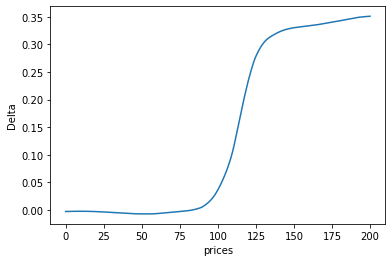

In [9]:
import pylab
prices = np.arange(0, 200, 0.1)
deltas = []
for p in prices:
    inputs = torch.tensor([[1, 90, 110.0, p, 0.25, 0., 0.]*3]).cuda() # T, B, K, S, sigma, mu, r
    deltas.append(model(inputs.float())[0][1]) # delta for S1

fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig